In [1]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as sio
import skimage.io
import h5py

import sys
sys.path.append('../Metric/')
from Metric import *
from Data_Extractor import *

Load & Reorder:

In [2]:
# Load
path_raw_image = "../../Data/090085/090085_20170531.h5"
path_road_mask = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert/motor_trunk_pri_sec_tert.tif"
path_topleft_coordinate = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert/topleft_coordinate_pos_neg.h5"

raw_image = np.array(h5py.File(path_raw_image)['scene'])
road_mask = skimage.io.imread(path_road_mask)

data = h5py.File(path_topleft_coordinate, 'r')

pos_topleft_coord = np.array(data['positive_example'])
neg_topleft_coord = np.array(data['negative_example'])
data.close()

print(raw_image.shape, road_mask.shape)
print(raw_image.min())

(7, 7961, 8091) (7961, 8091)
-9999


In [3]:
# Construct training & test set
pos_size = pos_topleft_coord.shape[0]
neg_size = neg_topleft_coord.shape[0]

np.random.shuffle(pos_topleft_coord)
np.random.shuffle(neg_topleft_coord)

Train_Data = Data_Extractor (raw_image, road_mask, 28,
                             pos_topleft_coord = pos_topleft_coord[:int(0.75*pos_size) ,:],
                             neg_topleft_coord = neg_topleft_coord[:int(0.75*neg_size) ,:])

Test_Data  = Data_Extractor (raw_image, road_mask, 28,
                             pos_topleft_coord = pos_topleft_coord[ int(0.75*pos_size):,:],
                             neg_topleft_coord = neg_topleft_coord[ int(0.75*neg_size):,:])

print(Train_Data.size, Test_Data.size)

12865796 4288600


Model parameters: 

In [4]:
width = 28
height = 28
band = 7

# Hyper parameters
conv_out = [0, 64, 128, 192]
last_conv_flatten = 4*4*conv_out[-1]
layer_out = [0, 256, 128]

class_output = 1 # number of possible classifications for the problem

uni = True # Xavier (uniform / normal)

keep_rate = 0.5 # need regularization => otherwise NaN appears inside CNN

batch_size = 64
learning_rate = 9e-6
iteration = 50000

Calculate Normalization Parameters:

In [6]:
# Normalize Parameters
mu = 0
sigma = 0
step = width
for img in Train_Data.iterate_raw_image_patches():
    mu += img
    assert (img != -9999).all()
mu = mu / Train_Data.size

for img in Train_Data.iterate_raw_image_patches():
    sigma += (img-mu)**2
sigma = sigma / Train_Data.size

print(mu.shape,    mu.dtype)
print(sigma.shape, sigma.dtype)

(5488,) float64
(5488,) float64


Place holders for inputs and outputs: 

In [7]:
x = tf.placeholder(tf.float32, shape=[None, height, width, band], name='x')
y = tf.placeholder(tf.float32, shape=[None, class_output], name='y')

keep_prob = tf.placeholder(tf.float32) # dropout
is_training = tf.placeholder(tf.bool, name='phase') # batch norm

Convolutional Layers:

In [8]:
# Convolutional Layer 1
W_conv1 = tf.get_variable('W_conv1', shape = [3, 3, band, conv_out[1]], 
                          initializer=tf.contrib.layers.xavier_initializer(uniform=uni))
b_conv1 = tf.Variable(tf.zeros([conv_out[1]]))

convolve1= tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
bn_1 = tf.contrib.layers.batch_norm(convolve1, center=True, scale=True, is_training=is_training)

h_conv1 = tf.nn.relu(convolve1)
conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Convolutional Layer 2
W_conv2 = tf.get_variable("W_conv2", shape = [3, 3, conv_out[1], conv_out[2]], 
                          initializer=tf.contrib.layers.xavier_initializer(uniform=uni))
b_conv2 = tf.Variable(tf.zeros([conv_out[2]]))

convolve2= tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')+ b_conv2
bn_2 = tf.contrib.layers.batch_norm(convolve2, center=True, scale=True, is_training=is_training)

h_conv2 = tf.nn.relu(convolve2)
conv2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Convolutional Layer 3
W_conv3 = tf.get_variable("W_conv3", shape = [3, 3, conv_out[2], conv_out[3]], 
                          initializer=tf.contrib.layers.xavier_initializer(uniform=uni))
b_conv3 = tf.Variable(tf.zeros([conv_out[3]]))

convolve3= tf.nn.conv2d(conv2, W_conv3, strides = [1, 1, 1, 1], padding='SAME')+ b_conv3
bn_3 = tf.contrib.layers.batch_norm(convolve3, center=True, scale=True, is_training=is_training)

h_conv3 = tf.nn.relu(convolve3)
conv3 = tf.nn.max_pool(h_conv3, ksize=[1,2,2,1], strides=[1, 2, 2, 1], padding='SAME')

# Flattening
layer2_matrix = tf.reshape(conv3, [-1,last_conv_flatten])

Fully Connected Layer: 

In [9]:
# Layer 1
W_fc1 = tf.get_variable('W_fc1', shape = [last_conv_flatten, layer_out[1]], 
                        initializer=tf.contrib.layers.xavier_initializer(uniform=uni))
b_fc1 = tf.Variable(tf.zeros([layer_out[1]]))

fcl=tf.matmul(layer2_matrix, W_fc1) + b_fc1
h_fc1 = tf.nn.relu(fcl)

# Drop out layer:
layer_drop = tf.nn.dropout(h_fc1, keep_prob)

# Layer 2
W_fc2 = tf.get_variable('W_fc2', shape = [layer_out[1], layer_out[2]], 
                        initializer=tf.contrib.layers.xavier_initializer(uniform=uni))
b_fc2 = tf.Variable(tf.zeros([layer_out[2]]))

fc2=tf.matmul(layer_drop, W_fc2) + b_fc2
h_fc2 = tf.nn.relu(fc2) # ReLU activation

Output Layer (Sigmoid):

In [10]:
W_fc_out = tf.get_variable('W_fc_out', shape = [layer_out[2], class_output], 
                        initializer=tf.contrib.layers.xavier_initializer(uniform=uni))

b_fc_out = tf.Variable(tf.zeros([class_output]))

fc_out = tf.matmul(h_fc2, W_fc_out) + b_fc_out

y_CNN = tf.sigmoid(fc_out, name='y_CNN')
prediction = tf.cast(tf.round(y_CNN), tf.int32, name='prediction')

Cost function & optimizer:

In [11]:
cross_entropy = -tf.reduce_mean(tf.reduce_sum((y * tf.log(y_CNN) + (1-y) * tf.log(1-y_CNN)), axis=1))

# Ensures that we execute the update_ops before performing the train_step
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

In [12]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(y, tf.round(y_CNN)), "float"))

Train & monitor:

In [13]:
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

learning_curve = []
for i in range(iteration):

    # force batch contains at least 1 positive example
    batch_x, batch_y = Train_Data.get_patches(batch_size=64, positive_num=12)
    batch = [((batch_x-mu)/sigma).reshape((-1,band,height,width)).transpose((0,2,3,1)).astype(np.float32), 
             np.matrix(batch_y).astype(int).T]

    train_step.run(feed_dict={x: batch[0], y: batch[1], keep_prob: keep_rate, is_training: True})
         
    # snap shot
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y: batch[1], keep_prob: 1})
        learning_curve.append(train_accuracy)
        
        print("acc = ", train_accuracy, " cross entropy = ", 
              cross_entropy.eval(feed_dict={x:batch[0], y: batch[1], keep_prob: 1}))

print("finish")

acc =  0.8125  cross entropy =  0.692818
acc =  0.8125  cross entropy =  0.433962
acc =  0.8125  cross entropy =  0.419627
acc =  0.8125  cross entropy =  0.40116
acc =  0.8125  cross entropy =  0.414914
acc =  0.8125  cross entropy =  0.42966
acc =  0.8125  cross entropy =  0.485548
acc =  0.8125  cross entropy =  0.4026
acc =  0.8125  cross entropy =  0.431201
acc =  0.8125  cross entropy =  0.500747
acc =  0.828125  cross entropy =  0.380755
acc =  0.84375  cross entropy =  0.385817
acc =  0.8125  cross entropy =  0.460981
acc =  0.828125  cross entropy =  0.374567
acc =  0.84375  cross entropy =  0.384948
acc =  0.796875  cross entropy =  0.438599
acc =  0.78125  cross entropy =  0.452457
acc =  0.875  cross entropy =  0.367388
acc =  0.828125  cross entropy =  0.35775
acc =  0.859375  cross entropy =  0.364038
acc =  0.8125  cross entropy =  0.408832
acc =  0.8125  cross entropy =  0.422019
acc =  0.8125  cross entropy =  0.361544
acc =  0.8125  cross entropy =  0.416513
acc =  0.

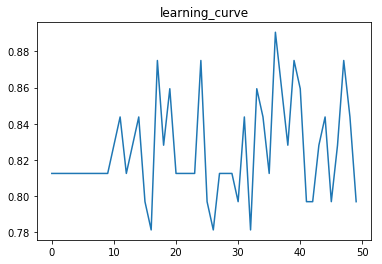

In [ ]:
# plot training curve
plt.figsize=(9,5)
plt.plot(learning_curve)
plt.title('learning_curve')
plt.show()

## (Optional) Save the model

In [ ]:
save_path = './Result/motor_trunk_pri_sec_tert/CNN - central pixel/'
model_name = 'motor_trunk_pri_sec_tert'
saver.save(sess, save_path + model_name)

h5f = h5py.File(save_path + "training_info.h5", 'w')

h5f_Index = h5f.create_group("Index")
h5f_Index_Train = h5f_Index.create_group(name='Train')
h5f_Index_Train = h5f_Index_Train.create_dataset (name='pos', data=Train_Data.pos_topleft_coord)
h5f_Index_Train = h5f_Index_Train.create_dataset (name='neg', data=Train_Data.neg_topleft_coord)
h5f_Index_Test  = h5f_Index.create_group(name='Test')
h5f_Index_Train = h5f_Index_Train.create_dataset (name='pos', data=Test_Data.pos_topleft_coord)
h5f_Index_Train = h5f_Index_Train.create_dataset (name='neg', data=Test_Data.neg_topleft_coord)

h5f_Norm = h5f.create_group("Norm")
h5f_Norm.create_dataset(name='mu', shape=mu.shape, data=mu)
h5f_Norm.create_dataset(name='sigma', shape=sigma.shape, data=sigma)
h5f.close()

Evaluate:

In [ ]:
train_metric = Metric()

for img, mask in Train_Data.iterate_data():
    batch = [((img-mu)/sigma).reshape((-1,band,height,width)).transpose((0,2,3,1)).astype(np.float32), 
             np.matrix(mask).astype(int).T]

    # record metric
    pred = prediction.eval(feed_dict={x:batch[0], keep_prob: 1, is_training: False})
    train_metric.accumulate(pred, batch[1])
    
train_metric.print_info()

In [ ]:
test_metric = Metric()

for img, mask in Test_Data.iterate_data():
    batch = [((img-mu)/sigma).reshape((-1,band,height,width)).transpose((0,2,3,1)).astype(np.float32), 
             np.matrix(mask).astype(int).T]
    
    # record metric
    pred = prediction.eval(feed_dict={x:batch[0], keep_prob: 1, is_training: False})
    test_metric.accumulate(pred, batch[1])
    
test_metric.print_info()